# Waste identification with instance segmentation in TensorFlow

Welcome to the Instance Segmentation Colab! This notebook will take you through the steps of running an "out-of-the-box" Mask RCNN Instance Segmentation model on images.

Given 3 different Mask RCNN models for the material type, material form type and plastic type, your goal is to inference with any of the models and visualize the results. 

To finish this task, a proper path for the TF Lite models and a single image needs to be provided. The path to the labels on which the models are trained is in the  waste_identification_ml directory inside the Tensorflow Model Garden repository. The label files are inferred automatically once you select the ML model by which you want to do the inference.

## Imports and Setup

Let's start with the base imports.

In [1]:
# install model-garden official
!pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 24.2 MB/s 
     |████████████████████████████████| 4.6 MB 33.0 MB/s 
     |████████████████████████████████| 116 kB 38.7 MB/s 
     |████████████████████████████████| 238 kB 37.0 MB/s 
     |████████████████████████████████| 99 kB 4.8 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.1 MB 41.3 MB/s 
     |████████████████████████████████| 636 kB 9.4 MB/s 
     |████████████████████████████████| 511.7 MB 5.1 kB/s 
     |████████████████████████████████| 352 kB 54.4 MB/s 
     |████████████████████████████████| 1.3 MB 59.3 MB/s 
     |████████████████████████████████| 438 kB 60.6 MB/s 
     |████████████████████████████████| 5.8 MB 63.2 MB/s 
     |████████████████████████████████| 1.6 MB 48.9 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=

In [2]:
import cv2

import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint

import numpy as np
from six import BytesIO
from PIL import Image
from six.moves.urllib.request import urlopen

from official.vision.ops.preprocess_ops import normalize_image

import tensorflow as tf

tf.get_logger().setLevel('ERROR')

## Visualization tools

To visualize the images with the proper detected boxes and segmentation masks, we will use the TensorFlow Object Detection API. To install it we will clone the repo.

In [3]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3442, done.
remote: Counting objects: 100% (3442/3442), done.
remote: Compressing objects: 100% (2887/2887), done.
remote: Total 3442 (delta 893), reused 1465 (delta 498), pack-reused 0
Receiving objects: 100% (3442/3442), 43.71 MiB | 24.91 MiB/s, done.
Resolving deltas: 100% (893/893), done.


Installing the Object Detection API

In [4]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1694955 sha256=ff7ab33e7f9cc48f0a8a837e9bfb7976346048b5cb040f16688a1ebf7f5c89f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-i0fh3jh3/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=3ab4b316e7e364a88dba0d8124cbc13868bdda38c2753ce3a309dfd66fe7e9e7
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.1.0 which is incompatible.


Now we can import the dependencies we will need later

In [5]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

## Import pre-trained models from the Waste Identification project

**Note** : users need to login into their Google account first to download public objects.

In [6]:
%%bash
gsutil cp gs://tf_model_garden/vision/waste_identification_ml/material_model.zip .
gsutil cp gs://tf_model_garden/vision/waste_identification_ml/material_form_model.zip .
gsutil cp gs://tf_model_garden/vision/waste_identification_ml/plastic_types_model.zip .
mkdir material material_form plastic_type
unzip material_model.zip -d material/
unzip material_form_model.zip -d material_form/
unzip plastic_types_model.zip -d plastic_type/

Archive:  material_model.zip
   creating: material/saved_model/
  inflating: material/saved_model/params.yaml  
   creating: material/saved_model/saved_model/
  inflating: material/saved_model/saved_model/saved_model.pb  
   creating: material/saved_model/saved_model/variables/
  inflating: material/saved_model/saved_model/variables/variables.data-00000-of-00001  
  inflating: material/saved_model/saved_model/variables/variables.index  
   creating: material/saved_model/checkpoint/
  inflating: material/saved_model/checkpoint/ckpt-1.data-00000-of-00001  
  inflating: material/saved_model/checkpoint/checkpoint  
  inflating: material/saved_model/checkpoint/ckpt-1.index  
   creating: material/tflite_model/
  inflating: material/tflite_model/model.tflite  
Archive:  material_form_model.zip
   creating: material_form/saved_model/
  inflating: material_form/saved_model/params.yaml  
   creating: material_form/saved_model/saved_model/
  inflating: material_form/saved_model/saved_model/saved

Copying gs://tf_model_garden/vision/waste_identification_ml/material_model.zip...
/ [1 files][497.2 MiB/497.2 MiB]                                                
Operation completed over 1 objects/497.2 MiB.                                    
Copying gs://tf_model_garden/vision/waste_identification_ml/material_form_model.zip...
| [1 files][499.3 MiB/499.3 MiB]                                                
Operation completed over 1 objects/499.3 MiB.                                    
Copying gs://tf_model_garden/vision/waste_identification_ml/plastic_types_model.zip...
\ [1 files][497.1 MiB/497.1 MiB]                                                
Operation completed over 1 objects/497.1 MiB.                                    


In [7]:
ALL_MODELS = {
'material_model' : 'material/tflite_model/model.tflite',
'material_form_model' : 'material_form/tflite_model/model.tflite',
'plastic_model' : 'plastic_type/tflite_model/model.tflite'
}

# path to an image
IMAGES_FOR_TEST = {
  'Image1' : 'models/official/projects/waste_identification_ml/pre_processing/config/sample_images/image_2.png'
}

## Utilities

Run the following cell to create some utils that will be needed later:

- Helper method to load an image

In [8]:
# Inputs to preprocess functions

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (1, h, w, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


def build_inputs_for_segmentation(image):
  """Builds segmentation model inputs for serving."""
  # Normalizes image with mean and std pixel values.
  image = normalize_image(image)
  return image

## Build an instance segmentation model and load pre-trained model weights

Here we will choose which Instance Segmentation model we will use.
If you want to change the model to try other architectures later, just change the next cell and execute following ones.

In [9]:
# @title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'material_form_model' # @param ['material_model','material_form_model','plastic_model']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:material_form_model
Model Handle at TensorFlow Hub: material_form/tflite_model/model.tflite


### Load label map data (for plotting).

Label maps correspond index numbers to category names, so that when our convolution network predicts `7`, we know that this corresponds to `tray`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

We are going, for simplicity, to load from the repository that we loaded the Object Detection API code

In [10]:
# @title Labels for the above model { display-mode: "form", run: "auto" }

if model_display_name == 'material_model':
  PATH_TO_LABELS = './models/official/projects/waste_identification_ml/pre_processing/config/data/material_labels.pbtxt'
elif model_display_name == 'material_form_model':
  PATH_TO_LABELS = './models/official/projects/waste_identification_ml/pre_processing/config/data/material_form_labels.pbtxt'
elif model_display_name == 'plastic_model':
  PATH_TO_LABELS = './models/official/projects/waste_identification_ml/pre_processing/config/data/plastic_type_labels.pbtxt'

print('Labels selected for',model_display_name)
print('\n')
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index

Labels selected for material_form_model




{1: {'id': 1, 'name': 'Flexibles'},
 2: {'id': 2, 'name': 'Bottle'},
 3: {'id': 3, 'name': 'Jar'},
 4: {'id': 4, 'name': 'Carton'},
 5: {'id': 5, 'name': 'Sachets-&-Pouch'},
 6: {'id': 6, 'name': 'Blister-pack'},
 7: {'id': 7, 'name': 'Tray'},
 8: {'id': 8, 'name': 'Tube'},
 9: {'id': 9, 'name': 'Can'},
 10: {'id': 10, 'name': 'Tub'},
 11: {'id': 11, 'name': 'Cosmetic'},
 12: {'id': 12, 'name': 'Box'},
 13: {'id': 13, 'name': 'Clothes'},
 14: {'id': 14, 'name': 'Bulb'},
 15: {'id': 15, 'name': 'Cup-&-glass'},
 16: {'id': 16, 'name': 'Book-&-magazine'},
 17: {'id': 17, 'name': 'Bag'},
 18: {'id': 18, 'name': 'Lid'},
 19: {'id': 19, 'name': 'Clamshell'},
 20: {'id': 20, 'name': 'Mirror'},
 21: {'id': 21, 'name': 'Tangler'},
 22: {'id': 22, 'name': 'Cutlery'},
 23: {'id': 23, 'name': 'Cassette-&-tape'},
 24: {'id': 24, 'name': 'Electronic-devices'},
 25: {'id': 25, 'name': 'Battery'},
 26: {'id': 26, 'name': 'Pen-&-pencil'},
 27: {'id': 27, 'name': 'Paper-products'},
 28: {'id': 28, 'name

## Loading the selected model 


In [11]:
print('loading model...')
interpreter = tf.lite.Interpreter(model_path=model_handle)
runner = interpreter.get_signature_runner()
print('model loaded!')

loading model...
model loaded!


In [12]:
# get signature list
pprint(interpreter.get_signature_list())

{'serving_default': {'inputs': ['inputs'],
                     'outputs': ['detection_boxes',
                                 'detection_classes',
                                 'detection_masks',
                                 'detection_scores',
                                 'image_info',
                                 'num_detections']}}


## Loading an image

Let's try the model on a simple image. 

Here are some simple things to try out if you are curious:
* Try running inference on your own images, just upload them to colab and load the same way it's done in the cell below.
* Modify some of the input images and see if detection still works.  Some simple things to try out here include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).

**Be careful:** when using images with an alpha channel, the model expect 3 channels images and the alpha will count as a 4th.



In [13]:
#@title Image Selection (don't forget to execute the cell!) { display-mode: "form"}
selected_image = 'Image1' # @param ['Image1']
flip_image_horizontally = False #@param {type:"boolean"}
convert_image_to_grayscale = False #@param {type:"boolean"}

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

print('min:',np.min(image_np[0]), 'max:', np.max(image_np[0]))
plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Pre-processing an image

In [14]:
# get an input size of images on which an Instance Segmentation model is trained

# Get model details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# read height and width
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

# verify input height and width
input_size = (height, width)
print('height = {}, width = {}'.format(height, width))

height = 512, width = 1024


In [15]:
# apply pre-processing functions which were applied during training the model
image_np_cp = cv2.resize(image_np[0], input_size[::-1], interpolation = cv2.INTER_AREA)
image_np = build_inputs_for_segmentation(image_np_cp)
image_np = tf.expand_dims(image_np, axis=0)
image_np.get_shape()

TensorShape([1, 512, 1024, 3])

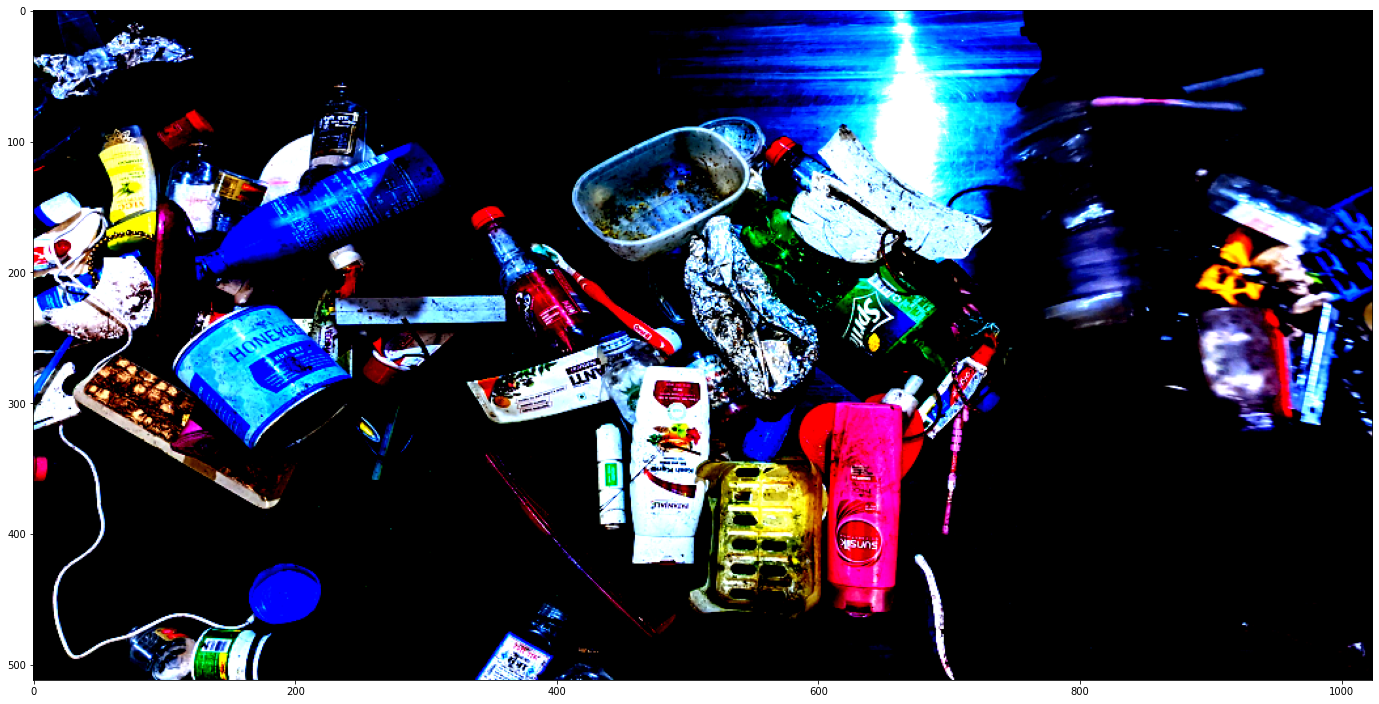

In [16]:
# display pre-processed image
plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

## Doing the inference

To do the inference we just need to call our TF Hub loaded model.

In [17]:
# running inference
result = runner(inputs=image_np)
print(result.keys())

dict_keys(['detection_boxes', 'detection_classes', 'detection_masks', 'detection_scores', 'image_info', 'num_detections'])


## Visualizing the results

Here is where we will need the TensorFlow Object Detection API to show the squares from the inference step (and the keypoints when available).

the full documentation of this method can be seen [here](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py)

Here you can, for example, set `min_score_thresh` to other values (between 0 and 1) to allow more detections in or to filter out more detections.

In [18]:
# selecting parameters for visualization
label_id_offset = 0
min_score_thresh =0.9
use_normalized_coordinates=True

if use_normalized_coordinates:
  # Normalizing detection boxes
  result['detection_boxes'][0][:,[0,2]] /= height
  result['detection_boxes'][0][:,[1,3]] /= width

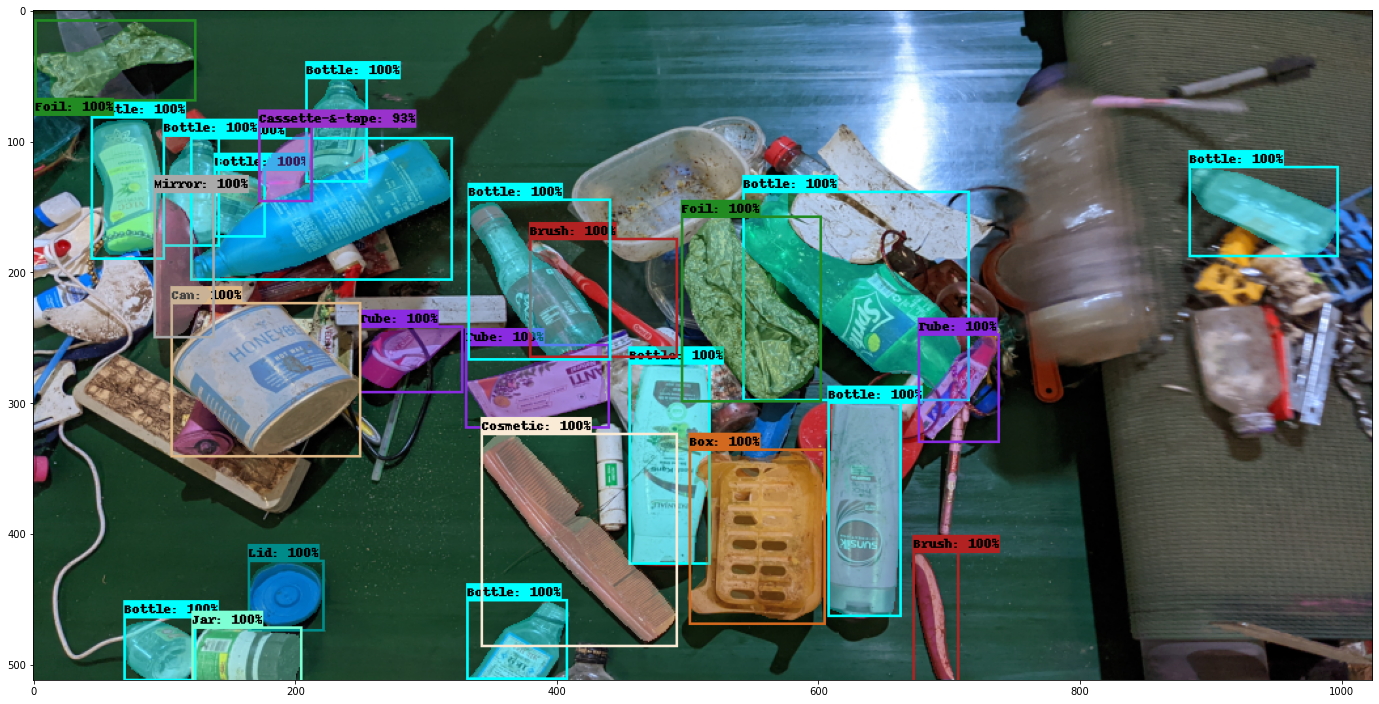

In [19]:
# Visualize detection and masks
if 'detection_masks' in result:
  # we need to convert np.arrays to tensors
  detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              image_np.shape[1], image_np.shape[2])
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                      np.uint8)

  result['detection_masks_reframed'] = detection_masks_reframed.numpy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_cp,
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index=category_index,
      use_normalized_coordinates=use_normalized_coordinates,
      max_boxes_to_draw=200,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=2)

plt.figure(figsize=(24,32))
plt.imshow(image_np_cp)
plt.show()

## Visualizing the masks only

Total number of objects found are: 26


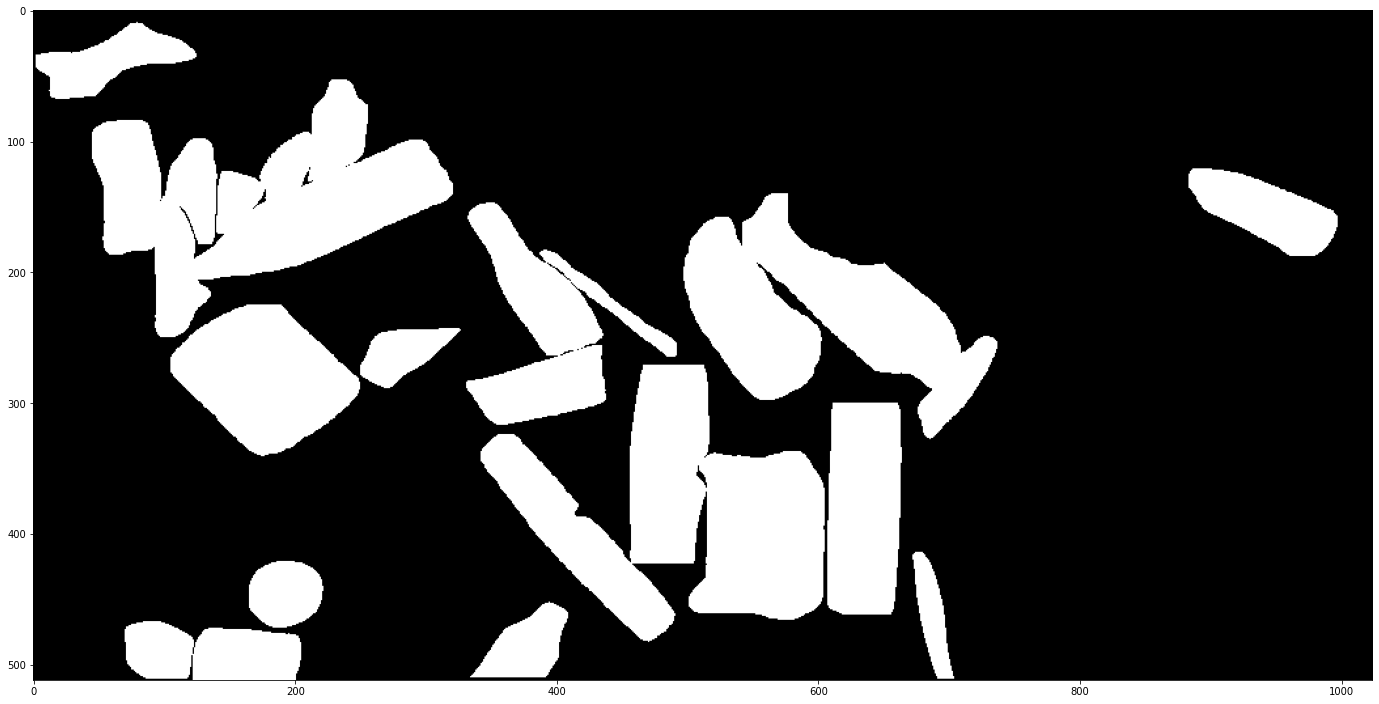

In [20]:
# collecting all masks and saving

mask_count = np.sum(result['detection_scores'][0] >= min_score_thresh)
print('Total number of objects found are:', mask_count)
mask = np.zeros_like(detection_masks_reframed[0])
for i in range(mask_count):
  if result['detection_scores'][0][i] >= min_score_thresh:
    mask += detection_masks_reframed[i]

mask = tf.clip_by_value(mask, 0,1)
plt.figure(figsize=(24,32))
plt.imshow(mask,cmap='gray')
plt.show()